In [1]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk 
from nltk import tokenize
from nltk.corpus import stopwords
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community  as nxcom

init_notebook_mode(connected=True)

nltk.download('stopwords')

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

[nltk_data] Downloading package stopwords to /home/lab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = read_mongo(db="heartbeat", collection="meetup")

df["event_duration"] = df.apply(lambda row:  datetime.strptime(row.event_hour_end, "%H:%M") - datetime.strptime(row.event_time, "%H:%M:%S") , axis = 1) 
unique_groups = df["group_name"].unique()
edges = []
persons = []


In [3]:
for g in unique_groups:
    group_events = df[df.group_name == g]
    
    for index, row in group_events.iterrows():
        event_attendees = row['event_attendees']

        for person in event_attendees:
            person_obj = {
                "id":person["id"], 
                "name":person["name"], 
                "group":row["group_name"],
                "event":row["event_title"],
                "profile":person["web_actions"]["group_profile_link"], 
                "gender":person["gender"],
                "coords":row["coords"]
            }
            persons.append(person_obj)
                
            rel = (person["id"], row["group_name"])
            edges.append(rel)
            
persons_dataframe = pd.DataFrame(persons)            
G = nx.Graph()
G.add_nodes_from(unique_groups, node_color='r')
G.add_edges_from(edges)            
persons_df = pd.DataFrame(persons)            
print("finished processing")

finished processing


In [5]:
print("Total number of events detected: "+ str(len(df["event_title"].unique())))
print("Total number of groups detected: "+ str(len(unique_groups)))
print("Total number of people involved in Meetup Paris at this time: " + str(len(persons_df["id"].unique())))
genders=(persons_df['gender'].value_counts(normalize=True) * 100)
print(str(genders[0])+ "% of users are male")
print(str(genders[1])+ "% of users are female")
print("but we have been able to guess the gender of "+str(genders[2]) + "%")

Total number of events detected: 185
Total number of groups detected: 68
Total number of people involved in Meetup Paris at this time: 2273
38.52033852033852% of users are male
34.15233415233415% of users are female
but we have been able to guess the gender of 27.32732732732733%


Most common words in event titles:
paris        63
picnic       31
online       31
apprendre    28
night        26
dtype: int64
Most common words in event descriptions:
paris        55
people       48
languages    44
language     41
every        37
dtype: int64
Word Clouds for title and description:


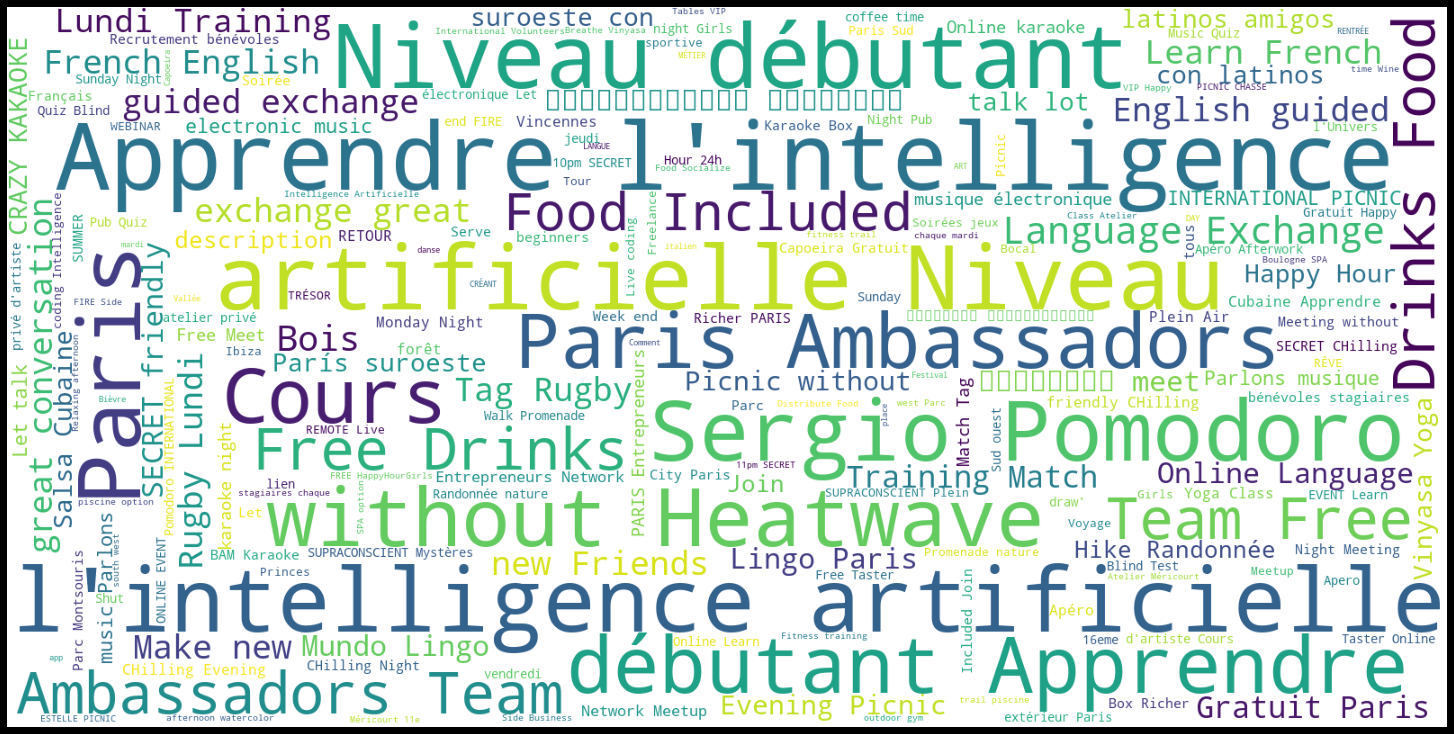

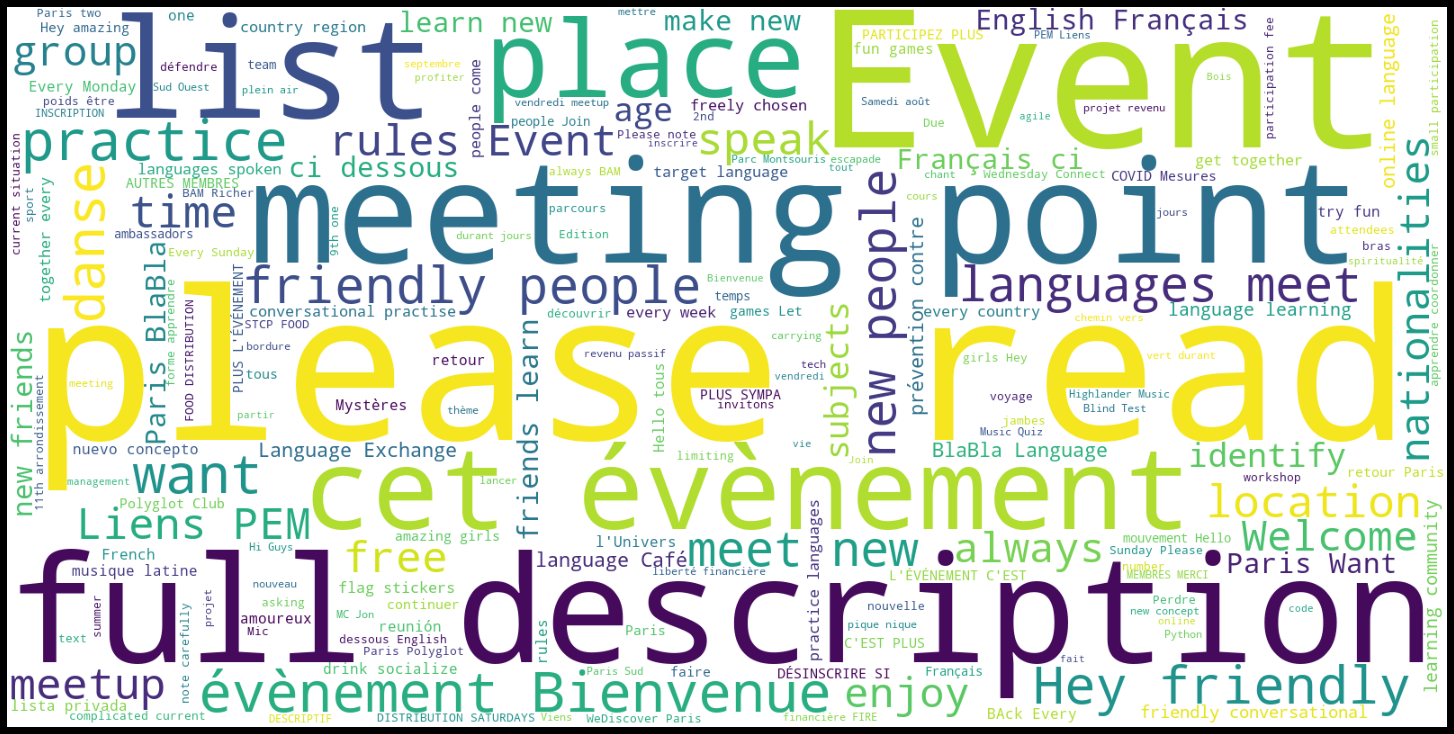

In [8]:
# TITLE/DESCRIPTION TEXT ANALYSIS
stopwords_fr = set(stopwords.words('french'))
stopwords_en = set(stopwords.words('english'))
spwords= stopwords_fr | stopwords_en 

print("Most common words in event titles:")
common = pd.Series(' '.join(df['event_title'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 4, i.split())))).lower().split()).value_counts()[:100]
print(common[:5])

text = " ".join(review for review in df.event_title)

wordcloud = WordCloud(width=1600, height=800, stopwords=spwords,background_color="white").generate(text)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)


print("Most common words in event descriptions:")
common = pd.Series(' '.join(df['event_desc'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 4, i.split())))).lower().split()).value_counts()[:100]
print(common[:5])

print("Word Clouds for title and description:")
text = " ".join(review for review in df.event_desc)

wordcloud = WordCloud(width=1600, height=800, stopwords=spwords,background_color="white").generate(text)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)



In [12]:
# sample visualization extracted from documentation, it works but looks ugly and hard to read
print("The Paris meetup network looks like this:")
pos = nx.spring_layout(G, k=0.05)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=8,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])    

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Meetup Paris network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)
# Number of communities, communities may or may not be related to group
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The meetup Paris network contains {len(communities)} communities.")

The Paris meetup network looks like this:


The meetup Paris network contains 35 communities.


In [15]:
# groups with more events / locations with more events
top_groups = df['group_name'].value_counts()[:10].index.tolist()
top_locations = df['event_location'][df['event_location'] != 'unknown'].value_counts()[:10].index.tolist()

print("Locations with more events: ")
print(top_locations)
print("Groups that offer more events: ")
print(top_groups)


Locations with more events: 
['Événement en ligne', 'Plaine Mortemart/Pershing', 'Vincennes ', 'The Highlander Scottish Pub Paris', 'Ground Control', 'DENFERT Café', 'Bar la Maizon', 'Le Piano Vache', 'Studio Massaro', 'Tennessee - Paris']
Groups that offer more events: 
['Dhaki-Data', 'meetup-group-SsrSLrps', 'promenades-et-randonnees', 'SUPRACONSCIENT-Spiritualite-et-Mysteres', 'LingUppParis', 'POTES-DE-SORTIES', 'PARIS-Entrepreneurs-Network-PEN', 'expatcontactinparis', 'FriendlySingles', 'Paris-Couchsurfing-International-Meetings']


In [36]:
# groups that mobilize the most people. Agg sum of attendees in all available events
df['num_attendees']  = (df['event_attendees'].str.len())
df['num_comments']  = (df['event_comments'].str.len())

print("Groups that mobilize more people:")
top_people = df.groupby(['group_name'])["num_attendees"].agg('sum').reset_index()
top_people = top_people.sort_values('num_attendees', ascending=False)[:5]
print(top_people)
fig = px.pie(top_people, values='num_attendees', names='group_name', title='Groups with more people')
fig.show()

print("Groups that generate more online comments:")
top_comments = df.groupby(['group_name'])["num_comments"].agg('sum').reset_index()
top_comments = top_comments.sort_values('num_comments', ascending=False)[:5]
print(top_comments)
fig = px.pie(top_comments, values='num_comments', names='group_name', title='Groups with more comments')
fig.show()

top_hours = df.groupby(['event_time'])["event_id"].count()
top_hours = top_hours.sort_values(ascending=False)
print("Most popular start hours:")
print(top_hours[:5])

print("Top event durations:")
top_durations = df.groupby(['event_duration'])["event_id"].count()
top_durations = top_durations.sort_values(ascending=False)
print(top_durations[:5])



Groups that mobilize more people:
                  group_name  num_attendees
66  promenades-et-randonnees            264
21               LEPARISAFRO            206
17    IBM-Cloud-Paris-Meetup            171
8               Events-Paris            166
6                  DDD-Paris            163


Groups that generate more online comments:
                                      group_name  num_comments
66                      promenades-et-randonnees            11
37                         Paris-Cycling-B-Group             5
27  Meetup-Reinventer-la-formation-en-presentiel             3
21                                   LEPARISAFRO             2
9                        ExpatriesTriathlonParis             2


Most popular start hours:
event_time
17:00:00    86
18:00:00    47
17:30:00    32
18:30:00    27
16:00:00    26
Name: event_id, dtype: int64
Top event durations:
event_duration
02:00:00    422
01:00:00     16
Name: event_id, dtype: int64


In [20]:
# Get percentages of men/women per event
def attendees_women(row, gender="women"):
    num_total = 0
    num_men = 0
    num_wom = 0
    for a in row["event_attendees"]:
        num_total += 1
        if a["gender"] == "male":
            num_men += 1
        elif a["gender"] == "female":
            num_wom += 1

    per_wom = num_wom / num_total
    per_men = num_men / num_total
    if gender == "women":
        return per_wom
    elif gender == "men":
        return per_men

In [21]:
# Get percentages of men/women per event
df['attendees_women'] = df.apply(lambda row: attendees_women(row), axis=1)
df['attendees_men'] = df.apply(lambda row: attendees_women(row, gender="men"), axis=1)
print("Events with higher % women")
print(df[df["num_attendees"]>10].sort_values('attendees_women',ascending=False)[["event_title","attendees_women"]])
print("Events with higher % women")
print(df[df["num_attendees"]>10].sort_values('attendees_men',ascending=False)[["event_title","attendees_men"]])

Events with higher % women
                                           event_title  attendees_women
20   Monet, Renoir, Chagall - L'Atelier des Lumière...         0.615385
352     Cabourg : Plage & Architecture - LONG DAY TRIP         0.600000
256    Ready-Set-Write!   (ambitious mid-week session)         0.571429
385  TEACH ENGLISH OR FRENCH TO PARIS REFUGEES & PR...         0.562500
245  Visite de l'Expo "Jusqu'ici tout va bien" au P...         0.551724
..                                                 ...              ...
191  Three ways to deploy a Python app into a Red H...         0.071429
284                                DDD clinic (online)         0.055215
211  Synthetic pitch - Centre Sportif Suzanne Lengl...         0.037037
303                Basketball - Bir-hakeim-Tour Effeil         0.000000
265  WEBINAR : Freelances, découvrez le Portage Sal...         0.000000

[83 rows x 2 columns]
Events with higher % women
                                           event_title  att

In [33]:
genders=(persons_dataframe['gender'].value_counts(normalize=True) * 100).reset_index()
genders=genders.rename(columns={"index":"gender","gender":"num" })
    
fig = px.bar(genders, x="gender", y="num")
fig.show()

In [24]:
# MAP POINTS 
# Problem! We need to do a bunch (un necessary) of data transformations here!!!
# Solutions, find a more intelligent way to send lat/long to plotly
# Store lat/long as separate fields in the scrapper...
df_geo = df[df['coords'].str.len() > 0]

#mnyeeeee
df_geo[['lat','lon']] = pd.DataFrame(df_geo['coords'].tolist(),index=df_geo.index)


top_coords = df.groupby(df_geo['coords'].map(tuple))['event_id'].count().to_frame('count').reset_index()
top_coords[['lat','lon']] = pd.DataFrame(top_coords['coords'].tolist(),index=top_coords.index)

mapbox_at= "pk.eyJ1IjoiY3VyYXNhbzk5IiwiYSI6ImNrZTl2eTJpeDJhaDEzN243YXdjY24zN20ifQ.cRm0go3r-tdZdTU-GBQitw"


# POINT (SCATTER) MAP

fig = px.scatter_mapbox(df_geo, lat="lat", lon="lon", color="group_name", size="num_attendees",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, center=dict(lat=48.864, lon=2.349), zoom=12)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=mapbox_at)
fig.show()

# HEAT DENSITY MAP

#px.set_mapbox_access_token(mapbox_at)

fig = px.density_mapbox(top_coords, lat="lat", lon="lon", z="count", radius=12,
                        center=dict(lat=48.864, lon=2.349), zoom=9)


fig.update_layout(mapbox_style="dark", mapbox_accesstoken=mapbox_at)
fig.show()

In [83]:
connections_influencers = []
influencers_ids = []

# Definition: Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
print("Betweenness centrality")
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
print("Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.")
for influencer in top_influencers:
    user_data = persons_dataframe[persons_dataframe["id"]==influencer].iloc[0]
    print("User: "+str(influencer)+"("+user_data["name"]+") Betweenness centrality coef: "+str(betCent.get(influencer))+" profile: "+user_data["profile"])
    connections_influencers += G.edges(influencer)
    if influencer not in influencers_ids:
        influencers_ids.append(influencer)

Betweenness centrality
Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
User: 314006705(Flore P.) Betweenness centrality coef: 0.08742837064115216 profile: https://www.meetup.com/Musees-et-expositions/members/314006705
User: 313399083(Essaadi) Betweenness centrality coef: 0.08656252128352364 profile: https://www.meetup.com/Musees-et-expositions/members/313399083
User: 224240227(Wilfried) Betweenness centrality coef: 0.05918958794688026 profile: https://www.meetup.com/FriendlySingles/members/224240227
User: 211271825(Saad G.) Betweenness centrality coef: 0.04704769554358367 profile: https://www.meetup.com/Agile-Nightmares-by-Digital-Catalysts/members/211271825
User: 314503967(Joe) Betweenness centrality coef: 0.03799821200659664 profile: https://www.meetup.com/promenades-et-randonnees/members/314503967


In [84]:
# Definition: Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
print("Degree centrality")
betCent = nx.degree_centrality(G)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
print("Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.")
for influencer in top_influencers:
    user_data = persons_dataframe[persons_dataframe["id"]==influencer].iloc[0]
    print("User: "+str(influencer)+"("+user_data["name"]+") Degree centrality coef: "+str(betCent.get(influencer))+" profile: "+user_data["profile"])
    connections_influencers += G.edges(influencer)
    if influencer not in influencers_ids:
        influencers_ids.append(influencer)

Degree centrality
Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
User: 314006705(Flore P.) Degree centrality coef: 0.002564102564102564 profile: https://www.meetup.com/Musees-et-expositions/members/314006705
User: 211271825(Saad G.) Degree centrality coef: 0.002564102564102564 profile: https://www.meetup.com/Agile-Nightmares-by-Digital-Catalysts/members/211271825
User: 279942924(Aby) Degree centrality coef: 0.002136752136752137 profile: https://www.meetup.com/paris-meetup-language-picnic-walk-socialize/members/279942924
User: 314257294(Myriam) Degree centrality coef: 0.002136752136752137 profile: https://www.meetup.com/Musees-et-expositions/members/314257294
User: 313399083(Essaadi) Degree centrality coef: 0.002136752136752137 profile: https://www.meetup.com/Musees-et-expositions/members/313399083


In [85]:
# Definition: EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.
# By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.
print("Eigenvector centrality")
betCent = nx.eigenvector_centrality(G)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
print("EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.")
for influencer in top_influencers:
    user_data = persons_dataframe[persons_dataframe["id"]==influencer].iloc[0]
    print("User: "+str(influencer)+"("+user_data["name"]+") Eigenvector centrality coef: "+str(betCent.get(influencer))+" profile: "+user_data["profile"])
    connections_influencers += G.edges(influencer)
    if influencer not in influencers_ids:
        influencers_ids.append(influencer)


Eigenvector centrality
EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.
User: 55243872(Christophe P.) Eigenvector centrality coef: 0.05917075312261184 profile: https://www.meetup.com/promenades-et-randonnees/members/55243872
User: 59726902(Géraldine) Eigenvector centrality coef: 0.05917075312261184 profile: https://www.meetup.com/promenades-et-randonnees/members/59726902
User: 297999354(Feriel) Eigenvector centrality coef: 0.05639518165245691 profile: https://www.meetup.com/promenades-et-randonnees/members/297999354
User: 187312254(nanouche007) Eigenvector centrality coef: 0.055822079072851534 profile: https://www.meetup.com/promenades-et-randonnees/members/187312254
User: 314307123(Djohra O.) Eigenvector centrality coef: 0.05551727680314575 profile: http

In [86]:
# Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network.
# This measure calculates the shortest paths between all nodes, then assigns each node a score based on its sum of shortest paths.
print("Closeness centrality")
betCent = nx.closeness_centrality(G)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
print("Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network.")
for influencer in top_influencers:
    user_data = persons_dataframe[persons_dataframe["id"]==influencer].iloc[0]
    print("User: "+str(influencer)+"("+user_data["name"]+") Closeness centrality coef: "+str(betCent.get(influencer))+" profile: "+user_data["profile"])
    connections_influencers += G.edges(influencer)
    

Closeness centrality
Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network.
User: 313399083(Essaadi) Closeness centrality coef: 0.24831747660309234 profile: https://www.meetup.com/Musees-et-expositions/members/313399083
User: 314006705(Flore P.) Closeness centrality coef: 0.24718062195457186 profile: https://www.meetup.com/Musees-et-expositions/members/314006705
User: 297999354(Feriel) Closeness centrality coef: 0.2329432740823098 profile: https://www.meetup.com/promenades-et-randonnees/members/297999354
User: 211271825(Saad G.) Closeness centrality coef: 0.2326922846694423 profile: https://www.meetup.com/Agile-Nightmares-by-Digital-Catalysts/members/211271825
User: 187312254(nanouche007) Closeness centrality coef: 0.23264215167694646 profile: https://www.meetup.com/promenades-et-randonnees/members/187312254


In [87]:
influencers_clean = []
for i in connections_influencers:
    dest = i[1]
    influencers_clean.append(dest)
    if influencer not in influencers_ids:
        influencers_ids.append(influencer)


print("Influencers center their activities around the following groups:")
idf = pd.DataFrame(influencers_clean, columns=["Group"])
fig = px.histogram(idf, y="Group")
fig.show()

Influencers center their activities around the following groups:


In [88]:
print("Influencers are attending the following events: ")
df_influencers = persons_df[persons_df["id"].isin(influencers_ids)]
print(df_influencers["event"].unique()[:10])
fig = px.histogram(df_influencers, x="event")
fig.show()

Influencers are attending the following events: 
['🌞 🍹 PARIS SUMMER PICNIC 🎉 - LANGUAGE EXCHANGE - EIFFEL TOWER'
 'Hike / Randonnée : la forêt de Montmorency (New)'
 "Randonnée : Forêt de Versailles- Marne la coquette - Etangs de Ville d'Avray"
 'Hike / Randonnée Nature : Chatou / Saint Germain en Laye / Maison-Laffitte '
 "Walk / Promenade nature : la forêt de Bois d'Arcy "
 'Walk / Promenade : Forêt de Saint Germain en Laye '
 'Hike / Randonnée Nature : La Rivière  du Roi Soleil  15/16 km'
 'Walk / Promenade Nature Parc Citroën, Petite Ceinture, Parc Brassens...'
 'Hike / Randonnée Versailles / Paris 2020 (Forests, Parks and cities) '
 'Programme PEM Août  Décembre 2020']


In [89]:
print("Influencers are moving around the following zones")
top_coords = df.groupby(df_influencers['coords'].map(tuple))['event_id'].count().to_frame('count').reset_index()
top_coords[['lat','lon']] = pd.DataFrame(top_coords['coords'].tolist(),index=top_coords.index)
fig = px.density_mapbox(top_coords, lat="lat", lon="lon", z="count", radius=12,
                        center=dict(lat=48.864, lon=2.349), zoom=9)


fig.update_layout(mapbox_style="basic", mapbox_accesstoken=mapbox_at)
fig.show()

Influencers are moving around the following zones
